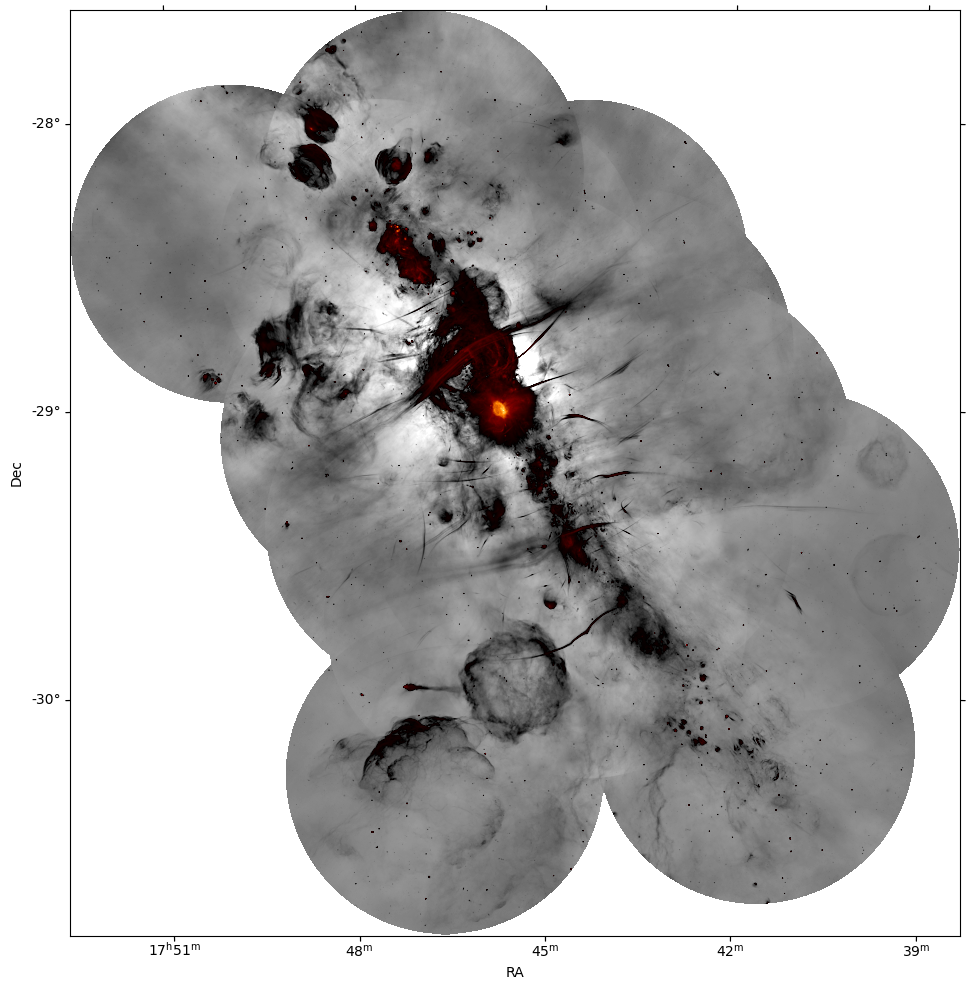

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import Normalize

class ThresholdSqrtNorm(Normalize):
    """
    Map values <= vmin to "under" (so cmap.set_under works),
    and apply sqrt stretch for values in [vmin, vmax].
    """
    def __call__(self, value, clip=None):
        v = np.array(value, copy=False)

        result = np.ma.array(v, copy=True)
        mask = ~np.isfinite(result)
        result = np.ma.masked_where(mask, result)

        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("vmin and vmax must be set")

        scaled = (result - vmin) / (vmax - vmin)
        scaled = np.ma.where(result >= vmin, np.sqrt(np.clip(scaled, 0, 1)), scaled)

        return scaled

# ----------------------------
# Settings
# ----------------------------
fits_path = "MeerKAT_Galactic_Centre_1284MHz-StokesI.fits"
hdu_index = 0

# values used in Heywood 2022
threshold = 0.4*1e-3  # Jy/beam
low_vmin = -0.4*1e-3
low_vmax = threshold
high_vmax = 350*1e-3

heat_cmap_name = "afmhot"

# ----------------------------
# Load
# ----------------------------
with fits.open(fits_path) as hdul:
    hdu = hdul[hdu_index]
    data = np.asarray(hdu.data, dtype=float)
    wcs = WCS(hdu.header).celestial



finite = np.isfinite(data)
if not np.any(finite):
    raise ValueError("No finite pixels in image.")

# ----------------------------
# Colormaps
# ----------------------------
heat_cmap = copy.copy(plt.get_cmap(heat_cmap_name))
heat_cmap.set_under((0, 0, 0, 0))  # transparent for under threshold


# ----------------------------
# Plot
# ----------------------------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)

# Faint layer: linear grayscale
im1 = ax.imshow(
    data,
    origin="lower",
    cmap="gray_r",
    vmin=low_vmin,
    vmax=low_vmax,
)

# Bright layer: sqrt, transparent under threshold
norm_hi = ThresholdSqrtNorm(vmin=threshold, vmax=high_vmax)
im2 = ax.imshow(
    data,
    origin="lower",
    cmap=heat_cmap,
    norm=norm_hi,
)

ax.set_xlabel("RA")
ax.set_ylabel("Dec")


plt.tight_layout()
plt.show()
